<center><h1>QBUS6840 - Predictive Analytics </h1></center>

# Tutorial 7 – Holt-Winters method
 
### Objectives:

- Implement Holt-Winter additive method manually
- Learn how to use `statsmodels` library to implement Holt-Winters’ method

In Week 6 tutorials, we learned how to use the simple exponential smoothing (SES) and trend corrected exponential smoothing (TCES - Holt’s linear) methods to smooth a time series and to make forecast. Although we could obtain reasonable outcome for simple cases, we have not considered the effect of seasonal effects could possibly exhibit in the time series.

In this tutorial, we will go one-step further, taking the seasonal component into account to build the model for forecasting/smoothing. The Holt-Winters smoothing methods are designed for this purpose by using exponential smoothing to model level, trend and seasonality. When doing forecasts, we rely on the forecast equation and three smoothing equations - one for the level $l_t$, one for the trend/slope $b_t$ and one for the seasonal component $S_t$, with the corresponding smoothing weights $\alpha$, $\beta$ and $\gamma$.

In this tutorial, we are interested in implementing the additive version of the Holt-Winters methods. In particular, we use the following equations to produce the one-step-ahead forecasts for the (monthly) number of visitors coming to Australia:

$$
\begin{eqnarray}
\widehat{Y}_{t+1|1:t} &=& l_t + b_t + S_{t+1- M}  \tag{1a} \\
l_t &=& \alpha (Y_t-S_{t-M}) + (1-\alpha) (l_{t-1}+b_{t-1}) \tag{1b} \\
b_t &=& \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1}  \tag{1c}\\
S_t &=& \gamma (Y_t - l_{t-1} - b_{t-1}) + (1-\gamma)S_{t-M} \tag{1d}
\end{eqnarray}
$$ 

with $l_t$, $b_t$ and $S_t$ the level, trend and seasonality at time $t=1,...,T$, respectively. $M$ is the seasonal period.  The time index of $S_{t+1- M}$ ensures that the estimates of the seasonal indices used for forecasting come from the final year of the observed data.

Holt-winters additive (or multiplicative) method is a parametric model with three parameters including $\alpha, \beta, \gamma$. The values of these parameters significantly affect the smoothness and forecast accuracy. Usually, if we are interested in doing forecast, we will select the besting fitting parameters by minimizing the SSE/MSE prediction error on in-sample data (normally we use in-sample/out-of-sample split). This results in a nonlinear optimization problem over $\alpha, \beta, \gamma$ (if we use SSE as the predictive measure):

$$ 
\alpha^*, \beta^*, \gamma^* = \text{argmin} \;\;SSE(\alpha,\beta,\gamma) 
\tag{2}
$$

where 

$$ 
SSE\;(\alpha,\beta,\gamma) = \sum_{t=1}^{T}(Y_t - l_{t-1} - b_{t-1} - S_{t-M})^2
\tag{3}
$$

The optimization problem in (2)-(3) can be solved using some optimization algorithms such as gradient descent or simply using grid search strategy to search for good values of $\alpha$, $\beta$, $\gamma$ like we did for the $\alpha$ parameter of SES in tutorial 6. However, we will not manually implement this optimization process but taking advantage the model fitting capability of the `ExponentialSmoothing` class of the well-known `statmodels` library, which is already installed in the Anaconda environment.

We also need to find good values for initial level $l_0$, slope/trend $b_0$ and $M$ initial seasonal values ($s_0,s_{-1},...,s_{-M+1}$). It is a common stratergy to do a linear regression over the data ($Y_1,...,Y_T$) to find initial level $l_0$, slope/trend $b_0$ as:

$$
\widehat{Y}_t = l_0 + b_0 t
\tag{4}
$$

Then calculate seasonal series as the residual, $\widehat{s}_t=Y_t -\widehat{Y}_t$, and then take the seasonal averages of $\widehat{s}_t$ as ($s_0,s_{-1},...,s_{-M+1}$).

**Note:** The initial values  $l_0$, $b_0$ and $(s_0,s_{-1},...,s_{-M+1})$ are often called hyper-parameters as they are less important in the model than the parameters $\alpha$, $\beta$, $\gamma$ and their values are normally selected using simple approaches as shown in the tutorial. 

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - Holt-Winters multiplicative smoothing </h3></div>

For Holt-Winters multiplicative smoothing, please refer to the lecture slides
and the text book: https://otexts.com/fpp2/holt-winters.html

## 1. Implement Holt-Winters smoothing/forecast manually

Let's starting with manually implement the Holt-Winters additive smoothing in order to gain a better understand about the model logics. 

### Importing the libraries and dataset:

Create a new Jupyter Notebook called "Tutorial_07.ipynb" and download the ***AustralianVisitors.csv*** file from Canvas. Let's begin our script by importing necessary libraries. We then load the dataset.

In [1]:
# Import some external libraries
import pandas as pd                               # For data manipulation
import matplotlib.pyplot as plt                   # For visualization
import numpy as np                                # For linear algebra
from sklearn.linear_model import LinearRegression # For Linear Regression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install statsmodels

 Plot the time series showing number of visitors to Australia during 1991-2016.

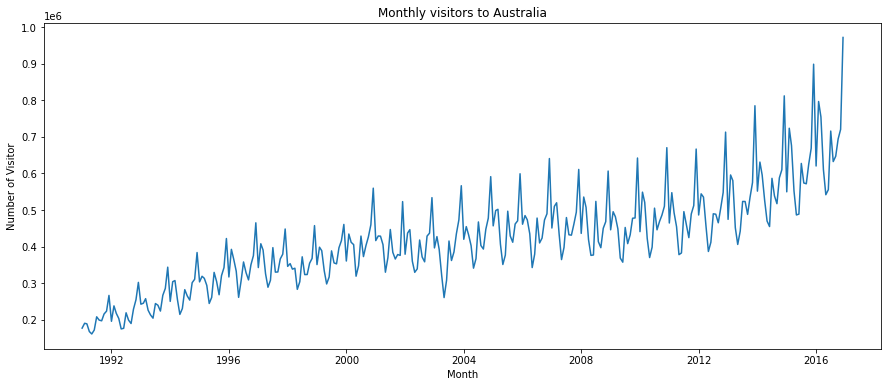

In [3]:
# Then read the data file into a DataFrame object
visitors = pd.read_csv('AustralianVisitors.csv')
visitors['Month']=pd.to_datetime(visitors['Month'])
visitors.set_index('Month', inplace=True)
visitors.head()

# Extract data
y = visitors['No of Visitors']

# Plot the time series
plt.figure(figsize=(15,6))
plt.plot(y.index,y)
plt.xlabel('Month')
plt.ylabel('Number of Visitor')
plt.title("Monthly visitors to Australia")
plt.show()


#原始資料s


### Define a function to calculate initial values of the Holt-Winters additive method

In order to implement a Holt-Winters additive smoothing to the given time-series data, we need to obtain many existing information as shown in the below check list. Make sure you obtain all these information:

| Information                             | Description                    |
|:----------                              | :-------------                 |
|<img width=200/>                         |<img width=200/>                |
| $Y_t$                                   | Observation y and time index t |
| $M$                                     | Seasonal period                |
| $\alpha, \beta, \gamma$                 | parameters               |
| $l_0, b_0$, $(s_0,s_{-1},...,s_{-M+1})$ | Initial values (hyper-parameters) |

Since the initialization step is a part of the whole process, it is useful to define a custom function, namely `linearOptimization()`, to find the good initial values for $l_0, b_0$ and $(s_0,s_{-1},...,s_{-M+1})$. We then will call this function inside another function implementing the Holt-Winters additive model. We will build a linear regression model for this purpose.

**Note:** As discussed in the introduction of the tutorial, we need to perform an optimization process to search for good values of model parameters $\alpha, \beta, \gamma$, and probaly $l_0, b_0$, $(s_0,s_{-1},...,s_{-M+1})$ too. However, for the purpose of showing how to obtain smoothed/forecast values with the Holt-Winters additive method, we assume that this optimization process has been done and we will use optimial values for $\alpha, \beta, \gamma$ to run the algorithm.  

Read the following code carefully and pay attention to the comments:

In [4]:
# Find l0, b0, and s0 using linear regression
def linearOptimization(X, m):
    
    # Prepare training data (X,y)
    x = np.linspace(1, len(X), len(X)) 
    x = np.reshape(x, (len(x), 1)) 
    y = np.reshape(X, (len(X), 1))
    
    # Train a linear regression to get l0 (intercept_) and b0 (coef_[0])
    lm = LinearRegression().fit(x, y)
    l0 = lm.intercept_
    b0 = lm.coef_[0]
    
    # Use trained linear regression model to get y^t
    # then s^ = y-y^
    # finally average s^ to get s
    # The following statement is equal to:
    #    res = y - lm.predict(x)+0.
    #    res = np.reshape(res,(m,int(len(X)/m)))
    #    s = np.mean(res,axis=0)
    s0 = np.mean(np.reshape(y + 0. - lm.predict(x),(int(len(X)/m),m)), axis=0)
    # in the above statement, 0. is used to transfer a int to float

    # return l0, b, and s
    return l0, b0, s0

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the data type of `l0`, `b0`, and `s0`?
- Is `s0` a scalar or an array?

### Define a new `addSeasonal()` function to implement the Holt-Winters smoothing method

Then we define a function to produce the smoothed and forecast values using the Holt-Winters additive method discussed in equation (1a)-1(d). The function will take the data $Y_{1:T}$, the sesonal period $M$ as required input arguments and $(\alpha,\beta,\gamma,l_0,b_0,s_0,s_{-1},...,s_{-M+1})$ as optional arguments. Calling this function, we can get the final smoothing/forecast values $\widehat{Y}_{1:T}$, the level $l_{1:T}$, slope $b_{1:T}$, the seasonal variations $S_{1:T}$ and in-sample predictive performance (such as SSE,RMSE, etc…) as the returning values.

**Note:** We will use the output $\widehat{Y}_{1:T}$ to extract the forecast/smoothed values of the original time series. For example, $\widehat{Y}_1$ is the smoothed value at time $t=1$ and forecast value at time $t=2$ and so on. 

Read the code below and pay attention to the comments to understand the logic.

In [5]:
def addSeasonal(Y, m, alpha = None, beta = None, gamma = None, \
                l0 = None, b0 = None, s = None):
    # Get time series length
    T = len(Y) 
    
    # Pre-allocating arrays storing level,trend,seasonality
    l = np.zeros(T)           # To store l0 level
    b = np.zeros(T)           # To store b0 trend
    s = np.zeros(T+m)         # To store s0 seasonal
    y_smoothed = np.zeros(T)  # To store smoothed value at time t
    
    # If parameters are not defined, use their default values 
    if (alpha == None or beta == None or gamma == None):
        alpha, beta, gamma = 0.1, 0.1, 0.1
        
    # If initial values for level, trend and seasonality have not initialized
    # Then call the linearOptimization() function to compute these values
    if (l0 == None or b0 == None or s == None):
        l0,b0,s0 = linearOptimization(Y,m)
    
    # Add initial values to the pre-allocated arrays for level, trend and seasonality
    s[:m] = s0
    l[0] = alpha*(Y[0]-s[0]) + (1-alpha)*(l0 + b0)   # Compute level at time t=1
    b[0] = beta*(l[0]-l0) + (1-beta)*b0              # Compute trend at time t=1
    s[m] = gamma*(Y[0]-l0-b0) + (1-gamma)*s[0]       # Compute seasonality at time t=1
    y_smoothed[0] = l[0]+b[0]+s[1]
    
    # Smoothing the time series. We start from time t=2
    for t in np.arange(1,T):
        
        # update the l,b,s and y
        l[t] = alpha*(Y[t]-s[t]) + (1-alpha) * (l[t-1] + b[t-1])
        b[t] = beta*(l[t]-l[t-1]) + (1-beta) * b[t-1]
        s[m+t] = gamma*(Y[t]-l[t-1]-b[t-1]) + (1-gamma)*s[t] 
        
        # Get smoothed value
        y_smoothed[t] = (l[t]+ b[t] + s[t+1])

    # Calculate the SSE of in-sample forecast
    SSE = np.sum(np.power(np.array(Y[1:]) - np.array(y_smoothed[:-1]),2))
    
    return y_smoothed, l, b, s[m:], SSE

Firstly, let’s understand the logic in this function. Below are some tips:

1. You may notice some input are set to `None`, i.e. `alpha = None`. By default, the function requires `x`, `m`, `h`, `alpha`, `beta`, `gamma`, `l0`, `b0`, and `s`, which is 9 variables as input. If you do not define/input the value of `alpha`, `beta`, `gamma`, `l0`, `b0`, and `s`, this `addSeasonal()` function will set them as `None` (default values). 
2. In the beginning, we pre-alllocated array of zeros for `l`, `b` and `s`. These variables are used as containers for saving the calculation results.
3. If we don't define the value of `alpha`, `beta`, `gamma`, we will set them equal to $0.1$. However, it is still suggested to build a model to find the best fitting values based on the observations, see equation (2) and (3).
4. If we don't define the `l0`, `b0`, and `s`, we will call the `linearOptimization()` to find the good fitting settings. Otherwise, we directly assign the predefined value to `l`, `b`, and `s`.
5. For each time index $t = 1:T$, we calculate the `l`, `b`, and `s`. When `t = T`, this means we reach the end of the last observations.

Now we are ready to implement the Holt-Winters additive smoothing/forecasting method by calling the `addSeasonal()` function we have just defined with corresponding input arguments provided.

In [6]:
 # Seasonal period
M = 12

# Call the addSeasonal() function to implement the Holt-Winters smoothing method
y_smoothed, l, b, s, SSE = addSeasonal(Y = y.tolist(), m = M)

# Store components in a Data Frame to plot. 
# These components are considered as latent states of underlying data generating process
states = pd.DataFrame(np.c_[l, b, s], columns=['Level','Trend','Seasonal']) 

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the meaning of `tolist()`?


### Visualize the results

Finally, we call `matplotlib` library to plot the smoothing results and the corresponding level, slope/trend and seasonal. Remember to call the `addSeasonal()` function to get the forecasting results.

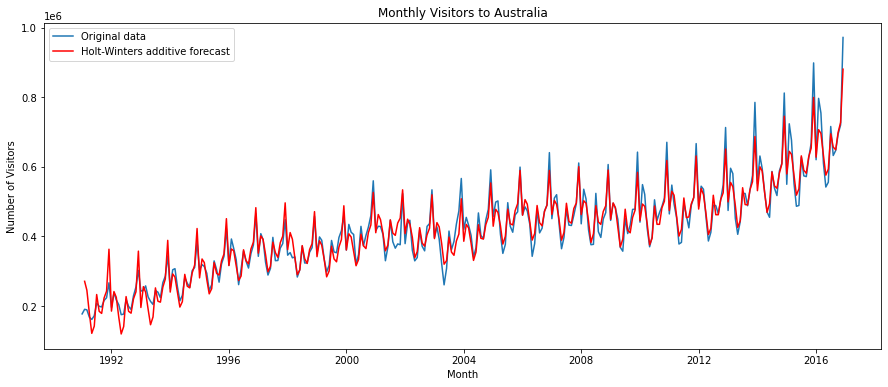

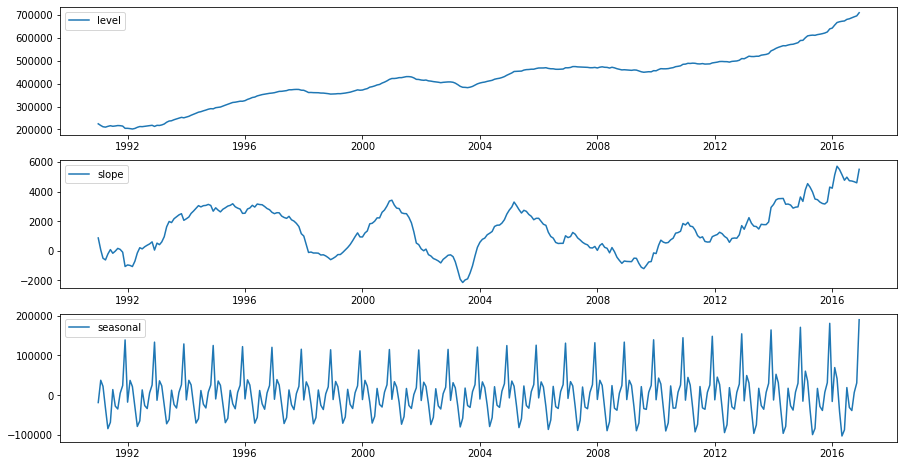

In [7]:
# Plot the original and one-step-ahead forecasted series 
plt.figure(figsize=(15,6))
plt.plot(y.index,y,label='Original data')
plt.plot(y.index[1:],y_smoothed[:-1], '-r', label='Holt-Winters additive forecast')
plt.title('Monthly Visitors to Australia')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.legend(loc=2)
plt.show()

# Plot level, trend and seasonality
fig, ax = plt.subplots(3, 1, figsize=(15,8))
ax[0].plot(y.index,states['Level'])
ax[1].plot(y.index,states['Trend'])
ax[2].plot(y.index,states['Seasonal'])
ax[0].legend(['level'])
ax[1].legend(['slope'])
ax[2].legend(['seasonal'])
plt.show()

In [28]:
# semsonla 不應該越來越大 理論上都要一樣最好


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the size of `l`, `b` and `s` in the above code?
- From the first figure, we can observe that the smoothed curve does not fit the observation very closely. Can you suggest some ways in order to obtain a more accurate result? **Hint**: think about the hyper parameters `alpha`, `beta`, `gamma`.

## 2. Holt-Winters smoothing in `statsmodels`

In this task we will use the build-in functions in statsmodels to smooth the data with Holt-Winters method. This implementation is much better than our manual implementation in Section 1 where we did not look for the best hyperparameters $\alpha, \beta, \gamma$.

### Step 1: Importing the libraries and dataset

From the `statsmodels.tsa.holtwinters` library import the `ExponentialSmoothing` function:

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# import warnings
# warnings.filterwarnings("ignore")

### Step 2: Call the ExponentialSmoothing function to smooth the time series

Holt-Winter smoothing method has two smoothing methods for seasonal variations: additive and multiplicative. For some simple cases, you can choose the suitable method by eye-looking. However, it is still suggested to do both methods and select the one with smaller residual for the forecasting.

Therefore, in this step we call the `ExponentialSmoothing()` function twice to smooth the time-series data with defining the additive and multiplicative seasonal variations decomposition respectively.

In [9]:
fit_add = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit() # Holt-Winters additive smoothing
fit_mul = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='mul').fit() # Holt-Winters multiplicative smoothing
import warnings
warnings.filterwarnings("ignore")

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Note that the `fit_add` and `fit_mul` are object type variables. If you want to know the fitting/smoothing results, you can print `.params[]` attributes, i.e. call `fit_add.params['smoothing_level']` to get the best fitting $\alpha$ value. Similarly, you can get the besting fitting $\beta, \gamma, l_0, b_0$ by calling corresponding attributes of `fit_add` and `fit_mul`. Below is an example:

In [10]:
# symbol r $ and \ in the results variable are the latex symbols for visualization in notebook
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit_add.params[p] for p in params] + [fit_add.sse]
results["Multiplicative"] = [fit_mul.params[p] for p in params] + [fit_mul.sse]
print(results)

              Additive  Multiplicative
$\alpha$  3.232143e-01    3.939286e-01
$\beta$   1.000000e-04    1.000000e-04
$\gamma$  3.825311e-01    2.203896e-01
$l_0$     1.997694e+05    1.997694e+05
$b_0$     1.352601e+03    1.352601e+03
SSE       1.371275e+11    1.132748e+11


**Note:** If you get an error saying that there is no attribute `smoothing_trend`, then you should update the latest version of `statmodels`. This step can be done easily by installing the latest version of Anaconda. 

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the size of `results` variable?
- What is the `sse` outcome for both decomposition? Based on this, which decomposition we should choose?

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - Holt-Winters in statsmodels </h3></div>

For more information of `holtwinter` function in `statsmodels` library, you can refer to the following two links:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.HoltWintersResults.html
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

### Step 3: Plot the smoothing results

After finding the best fitting parameters, we then need to plot the smoothing results. Here, you can call `.fittedvalues` attribute to check the smoothing results.

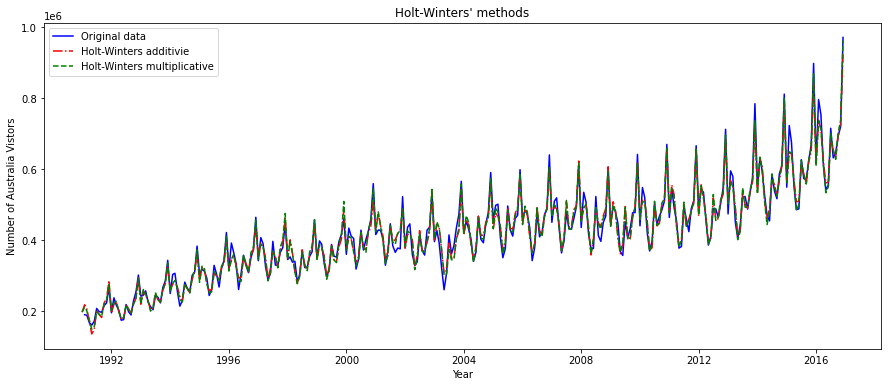

In [11]:
# Obtain fitted values from the fittedvalues attribute
smooth_add = fit_add.fittedvalues
smooth_mul = fit_mul.fittedvalues

# Plot all together
plt.figure(figsize=(15,6))
plt.plot(y[1:], 'b-', label = 'Original data')
plt.plot(smooth_add, 'r-.',label = 'Holt-Winters additivie')
plt.plot(smooth_mul, 'g--', label = 'Holt-Winters multiplicative')
plt.xlabel("Year")
plt.ylabel("Number of Australia Vistors")
plt.title("Holt-Winters' methods")
plt.legend()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the meaning of `'b-'`, `'r-.'`, `'g--'`?
- Compare the forecast values produced by the `ExponentialSmoothing` class and the manual implementation in Section 1, which one gives us better forecasts? Why?

### Step 4: Forecast the un-seen (future) data

Finally, based on the data $Y_{1:T}$ and best fitting parameters, let's forecast the number of visitors will come to Australia in the next one year. We can call the `.forecast()` method to forecast the $\widehat{Y}_{T+1},...,\widehat{Y}_{T+h}$, where $h=12$ in this case.

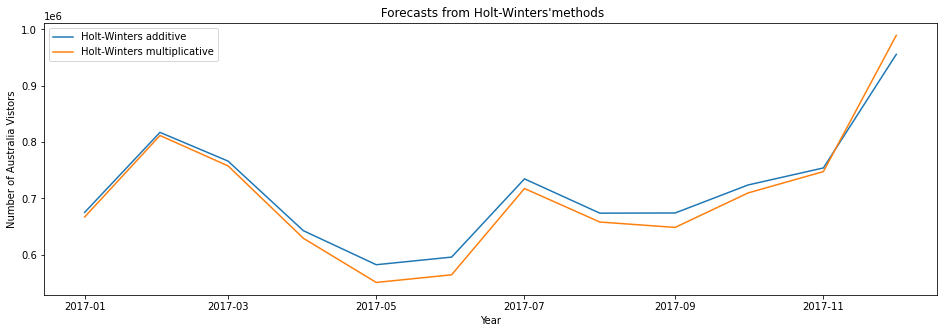

In [12]:
# Forecast 12 more data points
y_forecast_add = fit_add.forecast(12)
y_forecast_mul = fit_mul.forecast(12)

# And plot al together
plt.figure(figsize=(16,5))
plt.plot(y_forecast_add, label = 'Holt-Winters additive')
plt.plot(y_forecast_mul, label = 'Holt-Winters multiplicative')
plt.xlabel("Year")
plt.ylabel("Number of Australia Vistors")
plt.title(" Forecasts from Holt-Winters'methods")
plt.legend()
plt.show()


**Note:** If you want to compare the predictive performance of the Holt-Winters methods to other models, we need to perform the in-sample/out-of-sample split step and then evaluate the predictive performance of all models on the same out-of-sample data. We use in-sample data for model fitting. 

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the data type and size of variable `y_forecast_add` and `y_forecast_mul`?

## 3. Comparison of additive vs multiplicative

In many situations, we can use SSE or MSE for the quantitative performance analysis. However, sometimes we still need to plot the further information such as level, slope/trend and seasonal component for the qualitative analysis. In this step, we aim to extract the smoothing results and plot them in one window for comparison.

Extract the smoothing information and use `DataFrame` variable to save these them.

In [13]:
# Compare the forecasting outcomes of additive and multiplicative
# np.c_: Translates slice objects to concatenation along the second axis.

# For additive model
df_add = pd.DataFrame(np.c_[y, fit_add.level, fit_add.trend, fit_add.season, fit_add.fittedvalues], 
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=y.index)
df_add = df_add.append(fit_add.forecast(24).rename(r'$\hat{y}_t$').to_frame())

# For multiplicative model
df_mul = pd.DataFrame(np.c_[y, fit_mul.level, fit_mul.trend, fit_mul.season, fit_mul.fittedvalues], 
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=y.index)
df_mul = df_mul.append(fit_mul.forecast(24).rename(r'$\hat{y}_t$').to_frame())

Create a new fig window for plotting the level, slope and seasonal component results of additive and multiplicative decomposition. In this window, we have 3 rows and 2 columns, and the corresponding position is defined as ax1, ax2,..., ax6.

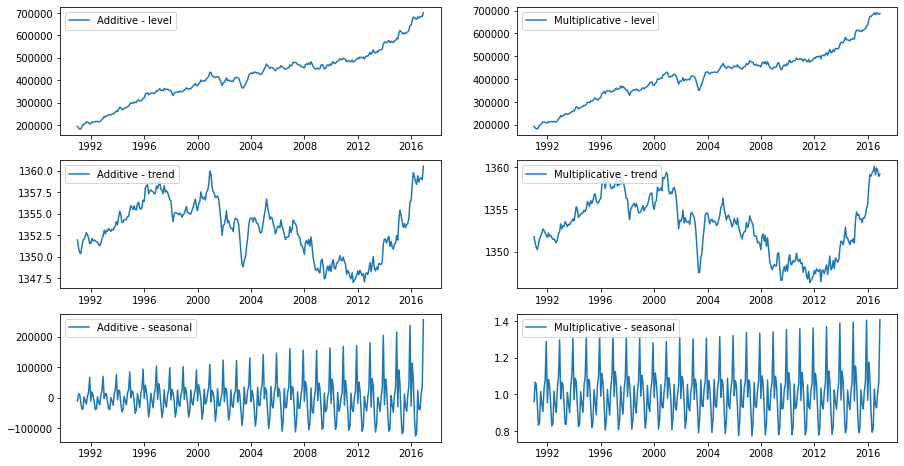

In [14]:
# Ploting the level, trend and season for fit_add and fit_mul
# Define 2 states variable for conveinence
states_add = pd.DataFrame(np.c_[fit_add.level, fit_add.trend, fit_add.season], \
                       columns=['level','trend','seasonal'], \
                       index=y.index)
states_mul = pd.DataFrame(np.c_[fit_mul.level, fit_mul.trend, fit_mul.season], \
                       columns=['level','trend','seasonal'], \
                       index=y.index)

# Define subplots windows
fig, ax = plt.subplots(3, 2, figsize=(15,8))
ax[0,0].plot(states_add['level'])
ax[1,0].plot(states_add['trend'])
ax[2,0].plot(states_add['seasonal'])
ax[0,1].plot(states_mul['level'])
ax[1,1].plot(states_mul['trend'])
ax[2,1].plot(states_mul['seasonal'])
ax[0,0].legend(['Additive - level'], loc=2)
ax[1,0].legend(['Additive - trend'], loc=2)
ax[2,0].legend(['Additive - seasonal'], loc=2)
ax[0,1].legend(['Multiplicative - level'], loc=2)
ax[1,1].legend(['Multiplicative - trend'], loc=2)
ax[2,1].legend(['Multiplicative - seasonal'], loc=2)

plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the level range for both methods?
- What is the slope range for both methods?
- What is the seasonal range for both methods?
- Let's put the residual aside and only consider the level, slope and seasonal.
- Based on these information, which decomposition method should you choose? Why?

# Tasks

In the Section 1 of Week 07 tutorial, we have learnt how to manually smooth a time series data with Holt-Winters method.
Continue with the week07 tutorial:
1. In the `addSeasonal()` function, change the $\alpha$ value from $0.1$ to $0.8$, what you could observe?
2. In the `addSeasonal()` function, change the $\beta$ value from $0.1$ to $0.8$, what you could observe?
3. In the `addSeasonal()` function, change the $\gamma$ value from $0.1$ to $0.8$, what you could observe?
4. Report the best fitting `alpha`, `beta` and `gamma` value of calling the `ExponentialSmoothing()` function. Then take these best fitting parameters as input of the `addSeasonal()` function. Compare your outcome of this manually defined function and the `ExponentialSmoothing()` function.
5. Based on the given sample code, could you please manually implement a HoltWinters' multiplicative smoothing by changing the calculation steps in `addSeasonal()` function? Then compare your result with the `ExponentialSmoothing()` function.
